In [27]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import glob, functools, tqdm, PIL
from multiprocess import Pool

def imread(fn):
    return np.array(PIL.Image.open(fn))

def imsize(fn):
    im = PIL.Image.open(fn)
    sz = im.size
    im.close()
    return sz

def is_landscape(fn): #landscape or portrait
    s = imsize(fn)
    return s[0] > s[1]

In [28]:
train = pd.DataFrame({'path':glob.glob('/home/mashrin/input/check/*')})
train['modelname'] = train.path.map(lambda p:p.split('/')[-1])

In [29]:
import cv2

def random_crop_fft(img, W):
    nr, nc = img.shape[:2]
    r1, c1 = np.random.randint(nr-W), np.random.randint(nc-W) 
    imgc = img[r1:r1+W, c1:c1+W, :]

    img1 = imgc - cv2.GaussianBlur(imgc, (3,3), 0)
    imgs1 = np.sum(img1, axis=2)
    
    sf = np.stack([
         np.fft.fftshift(np.fft.fft2( imgs1 )),
         np.fft.fftshift(np.fft.fft2( img1[:,:,0] - img1[:,:,1] )),
         np.fft.fftshift(np.fft.fft2( img1[:,:,1] - img1[:,:,2] )),
         np.fft.fftshift(np.fft.fft2( img1[:,:,2] - img1[:,:,0] )) ], axis=-1)
    return np.abs(sf)
    
def imread_residual_fft(fn, W, navg):
    #print(fn, rss())
    img = imread(fn).astype(np.float32) / 255.0
    return sum(map(lambda x:random_crop_fft(img, W), range(navg))) / navg

def noise_pattern(modelname, W, navg=256):
    files = train.path[train.modelname == modelname].values
    orientations = np.vectorize(is_landscape)(files)
    if np.sum(orientations) < len(orientations)//2:
        orientations = ~orientations
    files = files[orientations]

    from multiprocess import Pool
    with Pool() as pool:
        s = sum(tqdm.tqdm(pool.imap(lambda fn:imread_residual_fft(fn, W, navg), files), total=len(files), desc=modelname)) / len(files)
    
    return s

In [30]:
def plot_model_features(modelname, W):
    s = noise_pattern(modelname, W)
    nchans = s.shape[2]
    nrows = (nchans + 3) // 4
    _, ax = plt.subplots(nrows, 4, figsize=(16, 4 * nrows))
    ax = ax.flatten()

    for c in range(nchans):
        eps = np.max(s[:,:,c]) * 1e-2
        s1 = np.log(s[:,:,c] + eps) - np.log(eps) 
        img = (s1 * 255 / np.max(s1)).astype(np.uint8)
        ax[c].imshow(cv2.equalizeHist(img))
        
    for ax1 in ax[nchans:]:
        ax1.axis('off')

    plt.show()
    
def plot_all_model_features(W):
    print("Feature Size={}".format(W))
    for modelname in train.modelname.unique():
        plot_model_features(modelname, W)

Feature Size=128


1.jpg: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


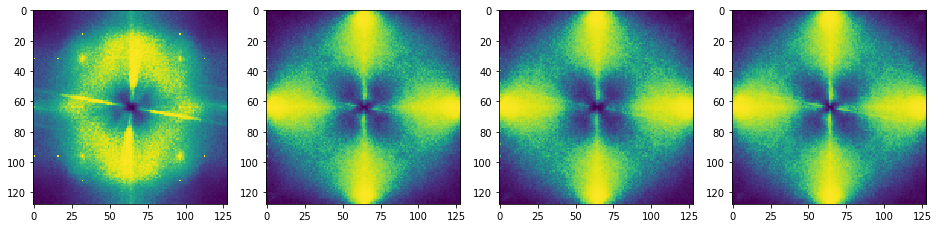

In [31]:
plot_all_model_features(W=128)

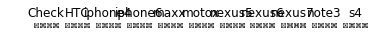

/usr/lib/python3/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


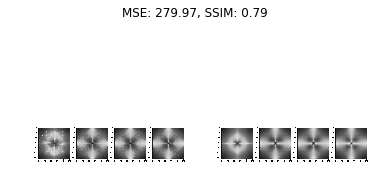

/usr/lib/python3/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


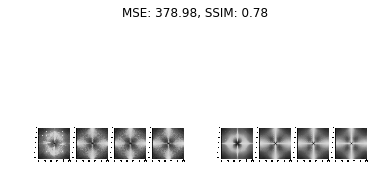

/usr/lib/python3/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


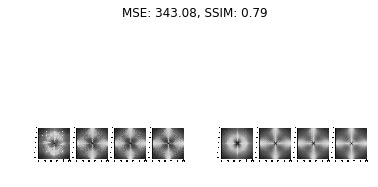

/usr/lib/python3/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


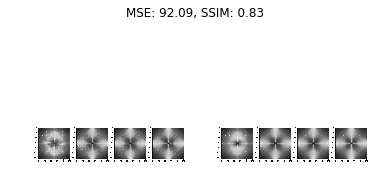

/usr/lib/python3/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


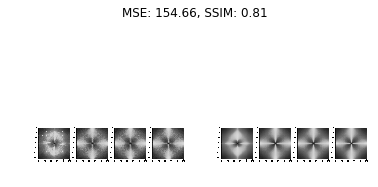

/usr/lib/python3/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


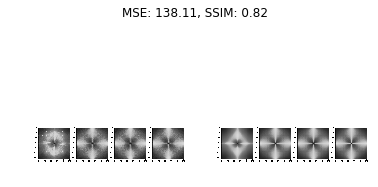

/usr/lib/python3/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


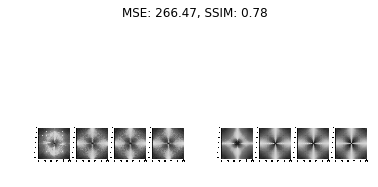

/usr/lib/python3/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


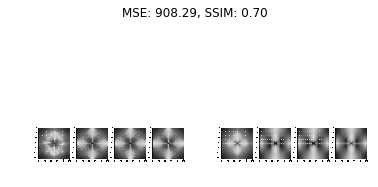

/usr/lib/python3/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


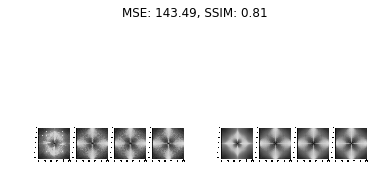

/usr/lib/python3/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


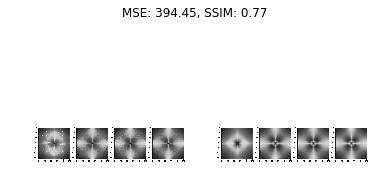

In [38]:
# import the necessary packages
from skimage.measure import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
import cv2

def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def compare_images(imageA, imageB, title):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)

    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))

    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")

    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")

    # show the images
    plt.show()

# load the images -- the original, the original + contrast,
# and the original + photoshop
check = cv2.imread("/home/mashrin/input/check2.png",0)
htc = cv2.imread("/home/mashrin/input/htc.png",0)
iphone4 = cv2.imread("/home/mashrin/input/iphone4.png",0)
iphone6 = cv2.imread("/home/mashrin/input/iphone6.png",0)
maxx = cv2.imread("/home/mashrin/input/maxx.png",0)
motox = cv2.imread("/home/mashrin/input/motox.png",0)
nexus5 = cv2.imread("/home/mashrin/input/nexus5.png",0)
nexus6 = cv2.imread("/home/mashrin/input/nexus6.png",0)
nexus7 = cv2.imread("/home/mashrin/input/nexus7.png",0)
note3 = cv2.imread("/home/mashrin/input/note3.png",0)
s4 = cv2.imread("/home/mashrin/input/s4.png",0)

# convert the images to grayscale
#original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
#contrast = cv2.cvtColor(contrast, cv2.COLOR_BGR2GRAY)
#shopped = cv2.cvtColor(shopped, cv2.COLOR_BGR2GRAY)

# initialize the figure
fig = plt.figure("Images")
#images = ("Original", original), ("Contrast", contrast), ("Photoshopped", shopped)
images = ("Check", check), ("HTC", htc), ("iphone4", iphone4), ("iphone6", iphone6), ("maxx", maxx), ("motox", motox), ("nexus5", nexus5), ("nexus6", nexus6), ("nexus7", nexus7), ("note3", note3), ("s4", s4)

# loop over the images
for (i, (name, image)) in enumerate(images):
    # show the image
    ax = fig.add_subplot(1, 11, i + 1)
    ax.set_title(name)
    plt.imshow(image, cmap = plt.cm.gray)
    plt.axis("off")

# show the figure
plt.show()

# compare the images
#compare_images(original, original, "Original vs. Original")
compare_images(check, htc, "Check vs. HTC")
compare_images(check, iphone4, "Check vs. iphone4")
compare_images(check, iphone6, "Check vs. iphone6")
compare_images(check, maxx, "Check vs. maxx")
compare_images(check, motox, "Check vs. motox")
compare_images(check, nexus5, "Check vs. nexus5")
compare_images(check, nexus6, "Check vs. nexus6")
compare_images(check, nexus7, "Check vs. nexus7")
compare_images(check, note3, "Check vs. note3")
compare_images(check, s4, "Check vs. s4")